# Dynamic WSCC 9-bus System with Switch Event

**Authors**:
 - Markus Mirz <mmirz@eonerc.rwth-aachen.de>
 - Steffen Vogel <stvogel@eoner.rwth-aachen.de>

This Jupyter Notebook shows a simple dynamic phasor simulation of the WSCC-9bus benchmark model.
The grid data is loaded from CIM-XML files, while simulation results are stored in CSV files and plotted via Matplotlib

In [1]:
%gui asyncio
#%matplotlib widget

import dpsim
from dpsim.Event import Event
import glob
import asyncio
import matplotlib.pyplot as plt

### Loading Grid Topology from CIM-XML Model

In [2]:
name = 'WSCC-9bus_dyn_switch'
files = glob.glob('../../dpsim/Examples/CIM/WSCC-09_RX_Dyn/*.xml')
print(files)
system = dpsim.load_cim(name, files, frequency=60)

['../../dpsim/Examples/CIM/WSCC-09_RX_Dyn/WSCC-09_RX_DI.xml', '../../dpsim/Examples/CIM/WSCC-09_RX_Dyn/WSCC-09_RX_EQ.xml', '../../dpsim/Examples/CIM/WSCC-09_RX_Dyn/WSCC-09_RX_SV.xml', '../../dpsim/Examples/CIM/WSCC-09_RX_Dyn/WSCC-09_RX_TP.xml']


### Rending Network Topology via Graphiz/SVG

We use Graphviz to render the network model into a layouted SVG figure

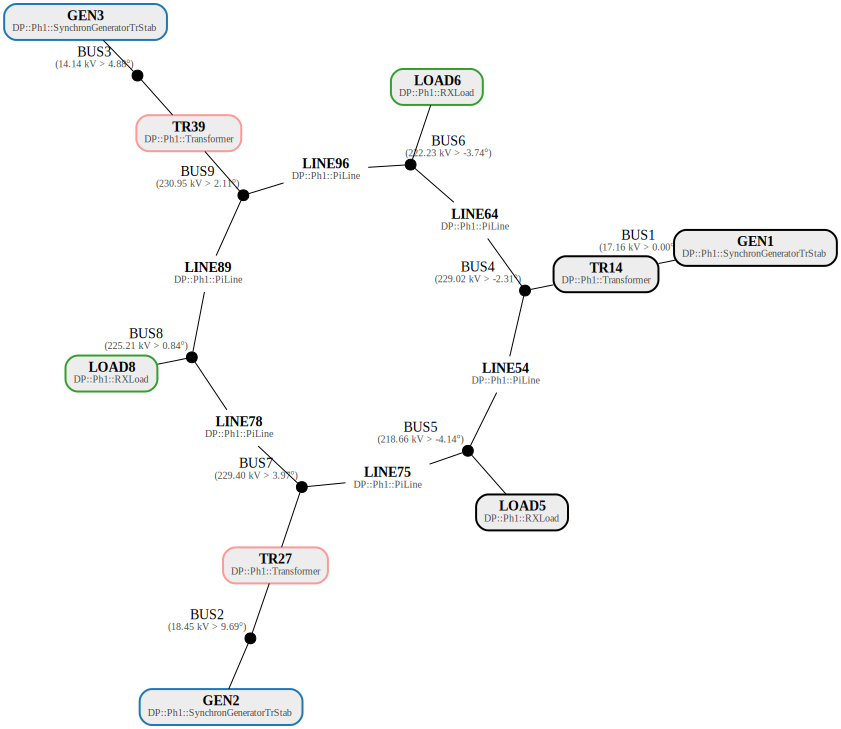

In [3]:
system

### Extending Network with Switch and Load

Here we add a new switch to Bus 9 that is triggered at 0.05s. This component could be added permantely to the CIM model as well using tools like Pintura.

In [4]:
## Switch
sw = dpsim.dp.ph1.Switch("Switch")

sw.R_open = 1e9
sw.R_closed = 0.1
sw.is_closed = False

## Load
load = dpsim.dp.ph1.PQLoadCS("Switched Load")

load.V_nom = 230950
load.P = 30000000
load.Q = 0

## Short
res = dpsim.dp.ph1.Resistor("Short")
res.R = 0.1

## Topology
bus9 = system.nodes["BUS6"]
#bus10 = dpsim.dp.Node("BUS10")
gnd = dpsim.dp.Node.GND()

#system.add_node(bus10)

#system.add_component(res)
#res.connect([bus10, gnd])

#system.add_component(load)
#load.connect([ bus10 ])

system.add_component(sw)
sw.connect([ bus9, gnd ])

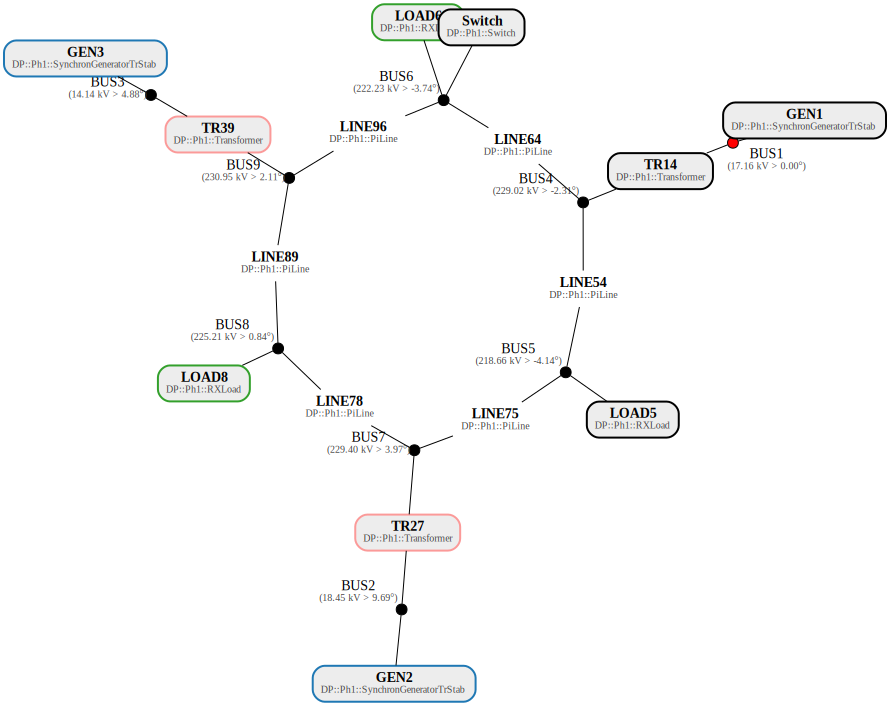

In [5]:
system

### Running Simulation

The actual simulation is done by the C++ DPsim solver. Python is just used for configuration, scripting and analysis

In [6]:
sim = dpsim.Simulation(name, system, timestep=0.0001, duration=2, init_steady_state=True, pbar=True)

system.components['GEN3'].inertia *= 2
sw.is_closed = False
sim.add_event(0.2, sw, 'is_closed', True)

logger = dpsim.Logger(name)
sim.add_logger(logger)
for i in range(1,4):
	logger.log_attribute(system.components['GEN%d' % i], 'w_r')

for node in system.nodes:
	logger.log_attribute(system.nodes[node], 'voltage')

sim.start()

HTML(value='Simulation start is pending...')

FloatProgress(value=0.0, max=2.0)

## Analysis

### Read log files and list all column names

In [7]:
from villas.dataprocessing.dpsim import *
from villas.dataprocessing.plottools import *

ts = read_timeseries_dpsim('Logs/WSCC-9bus_dyn_switch.csv')

DPsim results real column names: ['GEN1.w_r', 'GEN2.w_r', 'GEN3.w_r']
DPsim results complex column names: ['BUS1.voltage', 'BUS2.voltage', 'BUS3.voltage', 'BUS4.voltage', 'BUS5.voltage', 'BUS6.voltage', 'BUS7.voltage', 'BUS8.voltage', 'BUS9.voltage']
DPsim results variable number: 12
DPsim results length: 19990


### Phasors at first time step

In [8]:
phasors = get_node_voltage_phasors(ts)
for node, phasor in phasors.items():
    if 'voltage' in node:
        print(node + ': ' + str(phasor['abs'].values[0]) + '<' + str(phasor['phase'].values[0]))

BUS1.voltage: 17159.474013800347<-0.014700534417626102
BUS2.voltage: 18448.552726845748<9.668743412884451
BUS3.voltage: 14143.998836135344<4.8574713581968005
BUS4.voltage: 229023.7457343265<-2.3268263231006685
BUS5.voltage: 218644.37775942523<-4.162510248086312
BUS6.voltage: 222216.6971316316<-3.7614520308285213
BUS7.voltage: 229396.2693894976<3.947308163015826
BUS8.voltage: 225188.60501709953<0.8091655730457861
BUS9.voltage: 230944.17337474204<2.0813425517684685


### Phasors at last time step

In [9]:
for node, phasor in phasors.items():
    if 'voltage' in node:
        print(node + ': ' + str(phasor['abs'].values[-1]) + '<' + str(phasor['phase'].values[-1]))

BUS1.voltage: 13021.265859831625<2.0484585746086656
BUS2.voltage: 15109.6107749881<16.868968293201526
BUS3.voltage: 9416.10553216528<11.041210640185577
BUS4.voltage: 116599.26308274516<-1.2554447059164204
BUS5.voltage: 125811.70328858001<0.1490417453169411
BUS6.voltage: 358.00779579500295<-76.89980709030687
BUS7.voltage: 163455.90333546908<10.681269369786913
BUS8.voltage: 144776.2217252864<7.28015690881391
BUS9.voltage: 126156.86493337572<7.746692175072735


### Phasors at last time step in per unit

BUS1.voltage: 1.039968122048506<-0.014700534417626102
BUS2.voltage: 1.024919595935875<9.668743412884451
BUS3.voltage: 1.0249274518938656<4.8574713581968005
BUS4.voltage: 0.9957554162362022<-2.3268263231006685
BUS5.voltage: 0.9506277293888054<-4.162510248086312
BUS6.voltage: 0.9661595527462243<-3.7614520308285213
BUS7.voltage: 0.9973750843021635<3.947308163015826
BUS8.voltage: 0.9790808913786936<0.8091655730457861
BUS9.voltage: 1.0041051016293132<2.0813425517684685


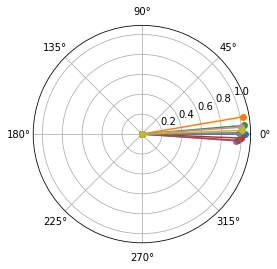

In [10]:
nominal_voltages = {
    'BUS1.voltage': 16.5e3,
    'BUS2.voltage': 18e3,
    'BUS3.voltage': 13.8e3, 
    'BUS4.voltage': 230e3,
    'BUS5.voltage': 230e3,
    'BUS6.voltage': 230e3, 
    'BUS7.voltage': 230e3,
    'BUS8.voltage': 230e3,
    'BUS9.voltage': 230e3
}

plt.figure(1)
for node, nom_voltage in nominal_voltages.items():
    mag = phasors[node]['abs'].values[0] / nom_voltage
    pha = phasors[node]['phase'].values[0]
    print(node + ': ' + str(mag) + '<' + str(pha))
    plt.polar([0, pha / 180 * np.pi], [0, mag], marker='o', label=node)
plt.show()

### Plot node phases

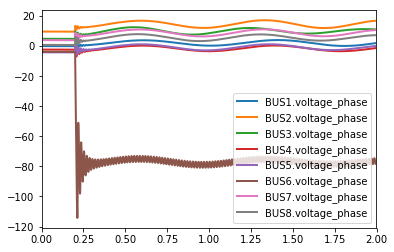

In [11]:
for i in range(1,9):
    plot_timeseries(20, phasors['BUS%d.voltage' % i]['phase'])

### Plot node voltages

(0.0, 0.06)

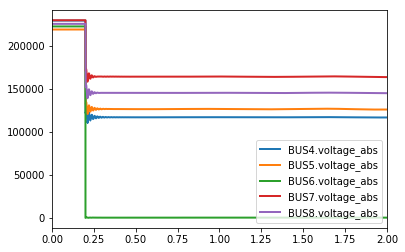

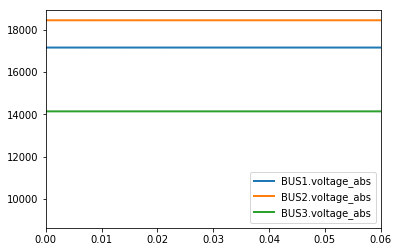

In [12]:
for i in range(4,9):
    plot_timeseries(10, phasors['BUS%d.voltage' % i]['abs'])
for i in range(1,4):
    plot_timeseries(11, phasors['BUS%d.voltage' % i]['abs'])
plt.xlim(0.0, 0.06)

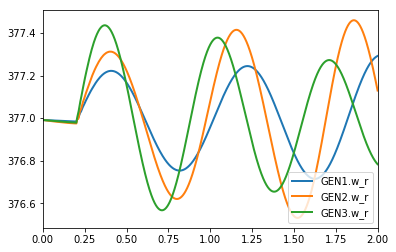

In [13]:
plot_timeseries(1, ts['GEN1.w_r'])
plot_timeseries(1, ts['GEN2.w_r'])
plot_timeseries(1, ts['GEN3.w_r'])